In [1]:
# Chapter1
# NN構築試行
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score  # モデルの評価を行うための関数
from keras import metrics
# 学習データ読み込み
data_X = pd.read_csv("train.csv")
data = data_X.dropna(how="any")
data.head()

Using TensorFlow backend.


,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0
5,5,2,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,flexible,NYC,t,...,-74.015729,"Close NYU Langone H, Room A/3min to Subway",Sunset Park,7,House,94.0,Private room,https://a0.muscache.com/im/pictures/dd071463-3...,11220,55.0
6,6,2,"{Internet,""Wireless Internet"",Kitchen,""Free pa...",1.5,Real Bed,1.0,1.0,moderate,NYC,t,...,-73.915965,Cozy Artist Bedroom less than 30 min to Manhattan,Bedford-Stuyvesant,65,House,91.0,Private room,https://a0.muscache.com/im/pictures/79595629/9...,11233,48.0
8,8,2,"{""Wireless Internet"",""Air conditioning"",""Pets ...",1.0,Real Bed,1.0,1.0,strict,SF,t,...,-122.411410,PERFECT Location in North Beach,North Beach,21,Apartment,87.0,Private room,https://a0.muscache.com/im/pictures/b1e47fdc-1...,94133,95.0


In [2]:
# # Chapter2
# 学習の再現を行うために乱数シードを固定するためのコード
import os
import random as rn
from tensorflow.compat.v1.keras import backend as K

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

tf.compat.v1.set_random_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)

pd.set_option("max_columns", None)
# pd.set_option('max_rows', None)

In [3]:
# Chapter3
# データ前処理
def pre_process(input_data_X: pd.DataFrame):
    # temp_data = input_data_X.drop(["id","amenities", "bed_type", "cancellation_policy", "city", "description", "first_review", "host_response_rate", "host_since"
    #                             , "last_review", "name", "neighbourhood", "property_type", "room_type", "thumbnail_url", "zipcode"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
    
    temp_data = input_data_X.drop(["id","amenities",  "description", "first_review", "host_response_rate", "host_since", "last_review", "name", "neighbourhood", "thumbnail_url", "zipcode"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
    temp_data = pd.get_dummies(temp_data)
    temp_data = temp_data.drop(["property_type_Earth House","property_type_Lighthouse","property_type_Tipi","property_type_Train","property_type_Treehouse","property_type_Vacation home"], axis=1, errors="ignore")


    processed_X = ((temp_data - temp_data.min()) / (temp_data.max() - temp_data.min()))
    # (x - train_stats['mean']) / train_stats['std']
    return processed_X
# train_dataset = data.sample(frac=0.8,random_state=0)
# test_dataset = data.drop(train_dataset.index)
train_dataset = data
test_dataset = data

train_y = train_dataset["y"]
test_y = test_dataset["y"]
train_X = pre_process(train_dataset.drop(["y"], axis=1))
test_X = pre_process(test_dataset.drop(["y"], axis=1))


In [4]:
# train_stats = train_dataset.describe()
# train_stats.pop("y")
# train_stats = train_stats.transpose()

# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_X)
# normed_test_data = norm(test_X)

In [5]:
test_X.dtypes

accommodates                           float64
bathrooms                              float64
bedrooms                               float64
beds                                   float64
cleaning_fee                           float64
host_has_profile_pic                   float64
host_identity_verified                 float64
instant_bookable                       float64
latitude                               float64
longitude                              float64
number_of_reviews                      float64
review_scores_rating                   float64
bed_type_Airbed                        float64
bed_type_Couch                         float64
bed_type_Futon                         float64
bed_type_Pull-out Sofa                 float64
bed_type_Real Bed                      float64
cancellation_policy_flexible           float64
cancellation_policy_moderate           float64
cancellation_policy_strict             float64
cancellation_policy_super_strict_30    float64
cancellation_

In [6]:
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import binary_accuracy, Accuracy
from tensorflow.keras.layers import SimpleRNN
import optuna


In [7]:
# hoge = train_dataset.drop(["id","amenities", "bed_type", "cancellation_policy", "city", "description", "first_review", "host_response_rate", "host_since"
#                                 , "last_review", "name", "neighbourhood", "property_type", "room_type", "thumbnail_url", "zipcode"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
# sns.pairplot(hoge[["y", "accommodates","host_identity_verified","instant_bookable", "number_of_reviews", "review_scores_rating"]], diag_kind="kde")

In [8]:
keras.backend.clear_session()
# Keras以外を利用するのも一つの手段。
model = keras.models.Sequential()
model.add(Dense(units=64, activation=tf.nn.relu, input_shape=[len(train_X.keys())])) 
# model.add(Dropout(0.5))
model.add(Dense(units=64, activation=tf.nn.relu)) 
# model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.mse,
        metrics=["mae", "mse"])

In [9]:
history = model.fit(x = train_X,
    y = train_y,
    batch_size = 8192, # バッチサイズ
    # epochs = 100, # エポック数
    epochs = 700, # エポック数
    validation_split = 0.1, # 検証データの割合
    # callbacks = [es_cb], # 早期終了の設定
    verbose = 1) # 進捗の確認を行うか（0:行わない, 1:行う）

495 - val_loss: 7124.9150 - val_mae: 48.6183 - val_mse: 7124.9150
Epoch 468/700
4/4 [==============================] - 0s 6ms/step - loss: 6981.8193 - mae: 46.9452 - mse: 6981.8193 - val_loss: 7125.4395 - val_mae: 48.5857 - val_mse: 7125.4395
Epoch 469/700
4/4 [==============================] - 0s 6ms/step - loss: 6974.5664 - mae: 47.1747 - mse: 6974.5664 - val_loss: 7118.9653 - val_mae: 49.0859 - val_mse: 7118.9653
Epoch 470/700
4/4 [==============================] - 0s 7ms/step - loss: 6974.1338 - mae: 47.5221 - mse: 6974.1338 - val_loss: 7118.1289 - val_mae: 48.9840 - val_mse: 7118.1289
Epoch 471/700
4/4 [==============================] - 0s 7ms/step - loss: 6969.9395 - mae: 47.3230 - mse: 6969.9395 - val_loss: 7117.7012 - val_mae: 48.7340 - val_mse: 7117.7012
Epoch 472/700
4/4 [==============================] - 0s 6ms/step - loss: 6968.4194 - mae: 47.1060 - mse: 6968.4194 - val_loss: 7114.2632 - val_mae: 48.7067 - val_mse: 7114.2632
Epoch 473/700
4/4 [==============================

KeyboardInterrupt: 

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,38307.089844,146.132446,38307.089844,38520.652344,146.204941,38520.652344,0
1,38224.730469,145.843048,38224.730469,38437.757812,145.913376,38437.757812,1
2,38140.828125,145.548065,38140.828125,38351.234375,145.607758,38351.234375,2
3,38051.949219,145.234924,38051.949219,38254.523438,145.265274,38254.523438,3
4,37950.484375,144.875610,37950.484375,38137.859375,144.853119,38137.859375,4


In [12]:
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
695,6750.530762,47.137207,6750.530762,6909.017090,48.501591,6909.017090,695
696,6745.075195,46.467133,6745.075195,6918.663086,48.265182,6918.663086,696
697,6747.140625,46.353710,6747.140625,6912.713379,48.551510,6912.713379,697
698,6743.287598,46.749649,6743.287598,6913.021484,48.847420,6913.021484,698
699,6744.605957,46.843674,6744.605957,6908.598633,48.640232,6908.598633,699


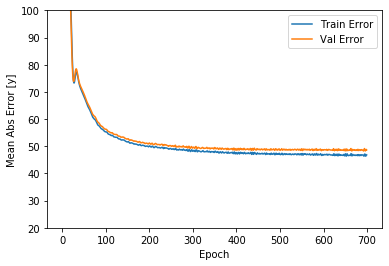

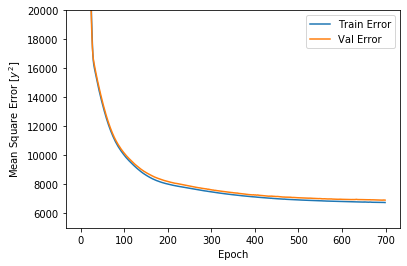

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [y]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([20,100])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$y^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([5000,20000])
  plt.legend()
  plt.show()


plot_history(history)

In [14]:
# 重回帰
# 説明変数の重みを確認
from sklearn import linear_model  # 線形回帰を行うためのモジュール
# 変数の準備
# X = data_oh.drop(["loan_status_ChargedOff", "loan_status_FullyPaid"], axis=1)  # 説明変数の設定
# y = data_oh["loan_status_FullyPaid"]  # 目的変数の設定

# 学習
lr = linear_model.LinearRegression()  # 線形回帰モデルのインスタンスを作成
lr.fit(train_X, train_y)  # 回帰の実行

# 結果の確認
print("回帰係数:")
print(pd.DataFrame({"Name": train_X.columns,
                    "Coefficients": lr.coef_}).sort_values(by='Coefficients'))  # 回帰係数
print("切片:", lr.intercept_)  # 切片
print("決定係数:", lr.score(train_X, train_y))  # 決定係数

回帰係数:
                                   Name  Coefficients
27                              city_SF -1.244466e+14
25                              city_LA -1.244466e+14
23                         city_Chicago -1.244466e+14
24                              city_DC -1.244466e+14
26                             city_NYC -1.244466e+14
22                          city_Boston -1.244466e+14
18         cancellation_policy_moderate -2.878706e+13
17         cancellation_policy_flexible -2.878706e+13
19           cancellation_policy_strict -2.878706e+13
20  cancellation_policy_super_strict_30 -2.878706e+13
21  cancellation_policy_super_strict_60 -2.878706e+13
56                room_type_Shared room -1.488410e+13
55               room_type_Private room -1.488410e+13
54            room_type_Entire home/apt -1.488410e+13
9                             longitude -1.201657e+04
42                 property_type_Hostel -1.883631e+02
39                   property_type_Dorm -1.531282e+02
44                    

In [15]:
test_X.dtypes

accommodates                           float64
bathrooms                              float64
bedrooms                               float64
beds                                   float64
cleaning_fee                           float64
host_has_profile_pic                   float64
host_identity_verified                 float64
instant_bookable                       float64
latitude                               float64
longitude                              float64
number_of_reviews                      float64
review_scores_rating                   float64
bed_type_Airbed                        float64
bed_type_Couch                         float64
bed_type_Futon                         float64
bed_type_Pull-out Sofa                 float64
bed_type_Real Bed                      float64
cancellation_policy_flexible           float64
cancellation_policy_moderate           float64
cancellation_policy_strict             float64
cancellation_policy_super_strict_30    float64
cancellation_

In [16]:
pd.set_option('max_rows', 100)
train_X.dtypes

accommodates                           float64
bathrooms                              float64
bedrooms                               float64
beds                                   float64
cleaning_fee                           float64
host_has_profile_pic                   float64
host_identity_verified                 float64
instant_bookable                       float64
latitude                               float64
longitude                              float64
number_of_reviews                      float64
review_scores_rating                   float64
bed_type_Airbed                        float64
bed_type_Couch                         float64
bed_type_Futon                         float64
bed_type_Pull-out Sofa                 float64
bed_type_Real Bed                      float64
cancellation_policy_flexible           float64
cancellation_policy_moderate           float64
cancellation_policy_strict             float64
cancellation_policy_super_strict_30    float64
cancellation_

In [17]:
data_X = pd.read_csv("test.csv")
test_X = pre_process(data_X)
y_proba = model.predict(test_X)
y_proba

array([[224.5194   ],
       [119.06908  ],
       [  1.8646581],
       ...,
       [  1.8646581],
       [158.65007  ],
       [ 41.960777 ]], dtype=float32)

In [18]:
np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\\result.dat", y_proba.astype("float"), fmt="%0.10f",)

In [19]:
hoge = y_proba.astype("float")

In [20]:
np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\\hoge.dat", hoge)